# Jonathan Halverson
# Saturday, February 10, 2018
# Home prices in California in Spark 2

In this notebook we perform linear regression and RF on some home prices.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()

In [3]:
housing_raw = spark.read.csv('Sacramentorealestatetransactions.csv', inferSchema=True, header=True)
housing_raw = housing_raw.withColumnRenamed('sq__ft', 'sqft')
all_wo_date = housing_raw.columns
all_wo_date.remove('sale_date')
housing_raw.select(all_wo_date).show(5)

+----------------+----------+-----+-----+----+-----+----+-----------+-----+---------+-----------+
|          street|      city|  zip|state|beds|baths|sqft|       type|price| latitude|  longitude|
+----------------+----------+-----+-----+----+-----+----+-----------+-----+---------+-----------+
|    3526 HIGH ST|SACRAMENTO|95838|   CA|   2|    1| 836|Residential|59222|38.631913|-121.434879|
|     51 OMAHA CT|SACRAMENTO|95823|   CA|   3|    1|1167|Residential|68212|38.478902|-121.431028|
|  2796 BRANCH ST|SACRAMENTO|95815|   CA|   2|    1| 796|Residential|68880|38.618305|-121.443839|
|2805 JANETTE WAY|SACRAMENTO|95815|   CA|   2|    1| 852|Residential|69307|38.616835|-121.439146|
| 6001 MCMAHON DR|SACRAMENTO|95824|   CA|   2|    1| 797|Residential|81900| 38.51947|-121.435768|
+----------------+----------+-----+-----+----+-----+----+-----------+-----+---------+-----------+
only showing top 5 rows



In [4]:
housing_raw.toPandas().head(3).T

,0,1,2
street,3526 HIGH ST,51 OMAHA CT,2796 BRANCH ST
city,SACRAMENTO,SACRAMENTO,SACRAMENTO
zip,95838,95823,95815
state,CA,CA,CA
beds,2,3,2
baths,1,1,1
sqft,836,1167,796
type,Residential,Residential,Residential
sale_date,Wed May 21 00:00:00 EDT 2008,Wed May 21 00:00:00 EDT 2008,Wed May 21 00:00:00 EDT 2008
price,59222,68212,68880


In [5]:
from pyspark.sql.functions import to_timestamp
housing = housing_raw.withColumn('sale_date', to_timestamp('sale_date', 'EEE MMM d H:mm:ss z yyyy'))

In [6]:
housing.printSchema()

root
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- sqft: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- sale_date: timestamp (nullable = true)
 |-- price: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)



In [7]:
housing.groupBy('sale_date').count().show()

+-------------------+-----+
|          sale_date|count|
+-------------------+-----+
|2008-05-19 00:00:00|  268|
|2008-05-21 00:00:00|  158|
|2008-05-15 00:00:00|  118|
|2008-05-16 00:00:00|  264|
|2008-05-20 00:00:00|  177|
+-------------------+-----+



In [8]:
housing.select('beds', 'baths', 'sqft', 'price', 'latitude').describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|              beds|             baths|              sqft|             price|           latitude|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|               985|               985|               985|               985|                985|
|   mean|2.9116751269035532|1.7766497461928934|1314.9167512690356|234144.26395939087| 38.607732086294504|
| stddev|1.3079322320435807|0.8953714223186463| 853.0482425034448|138365.83908492787|0.14543287915296987|
|    min|                 0|                 0|                 0|              1551|          38.241514|
|    max|                 8|                 5|              5822|            884790|          39.020808|
+-------+------------------+------------------+------------------+------------------+-------------------+



In [9]:
housing.count()

985

In [10]:
housing.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
street       985 non-null object
city         985 non-null object
zip          985 non-null int64
state        985 non-null object
beds         985 non-null int64
baths        985 non-null int64
sqft         985 non-null int64
type         985 non-null object
sale_date    985 non-null datetime64[ns]
price        985 non-null int64
latitude     985 non-null float64
longitude    985 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 92.4+ KB


In [11]:
housing = housing.drop('state', 'street')

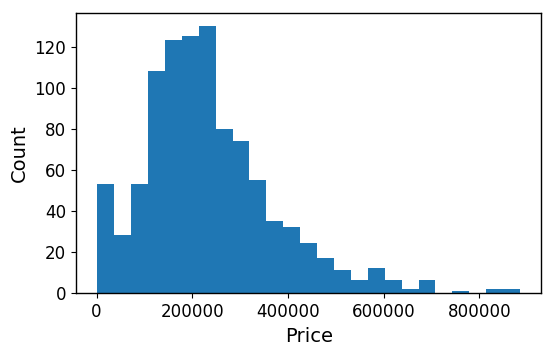

In [12]:
plt.hist(housing.select('price').rdd.map(lambda x: x[0]).collect(), bins=25)
plt.xlabel('Price')
plt.ylabel('Count')

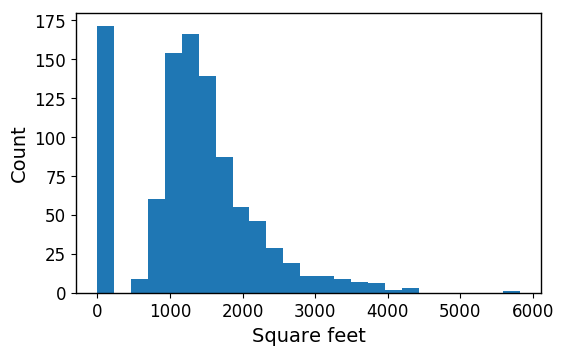

In [13]:
plt.hist(housing.select('sqft').rdd.map(lambda x: x[0]).collect(), bins=25)
plt.xlabel('Square feet')
plt.ylabel('Count')

In [14]:
housing.groupBy('baths').count().orderBy('baths').show()

+-----+-----+
|baths|count|
+-----+-----+
|    0|  108|
|    1|  180|
|    2|  544|
|    3|  132|
|    4|   19|
|    5|    2|
+-----+-----+



In [15]:
housing.groupBy('beds').count().orderBy('beds').show()

+----+-----+
|beds|count|
+----+-----+
|   0|  108|
|   1|   10|
|   2|  133|
|   3|  413|
|   4|  258|
|   5|   59|
|   6|    3|
|   8|    1|
+----+-----+



In [16]:
housing.groupBy('type').count().orderBy('type').show()

+------------+-----+
|        type|count|
+------------+-----+
|       Condo|   54|
|Multi-Family|   13|
| Residential|  917|
|      Unkown|    1|
+------------+-----+



In [17]:
housing = housing.withColumn('total_rooms', housing.beds + housing.baths)
housing.select('beds', 'baths', 'total_rooms', 'price').show()

+----+-----+-----------+------+
|beds|baths|total_rooms| price|
+----+-----+-----------+------+
|   2|    1|          3| 59222|
|   3|    1|          4| 68212|
|   2|    1|          3| 68880|
|   2|    1|          3| 69307|
|   2|    1|          3| 81900|
|   3|    1|          4| 89921|
|   3|    2|          5| 90895|
|   3|    1|          4| 91002|
|   2|    2|          4| 94905|
|   3|    2|          5| 98937|
|   3|    2|          5|100309|
|   3|    2|          5|106250|
|   1|    1|          2|106852|
|   3|    1|          4|107502|
|   2|    2|          4|108750|
|   2|    2|          4|110700|
|   2|    1|          3|113263|
|   2|    1|          3|116250|
|   2|    1|          3|120000|
|   3|    2|          5|121630|
+----+-----+-----------+------+
only showing top 20 rows



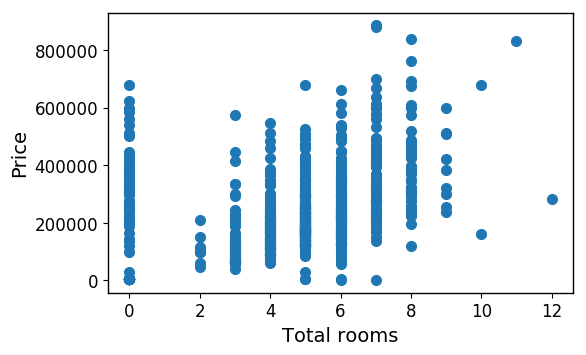

In [18]:
x = housing.rdd.map(lambda row: row.total_rooms).collect()
y = housing.rdd.map(lambda row: row.price).collect()
plt.scatter(x, y)
plt.xlabel('Total rooms')
plt.ylabel('Price')

In [19]:
import numpy as np
np.cov(x, y) / np.std(x) / np.std(y)

array([[  1.53109375e-05,   3.87853892e-01],
       [  3.87853892e-01,   6.54456040e+04]])

In [20]:
from pyspark.sql import functions as F
housing.groupBy('city').agg(F.avg('price'), F.count('*')).orderBy('avg(price)').show(100)

+---------------+------------------+--------+
|           city|        avg(price)|count(1)|
+---------------+------------------+--------+
|    SLOUGHHOUSE|            2000.0|       1|
|        LINCOLN| 96539.26388888889|      72|
|        ELVERTA|          132866.0|       4|
|NORTH HIGHLANDS|135659.33333333334|      21|
|WEST SACRAMENTO|          170700.0|       3|
|      RIO LINDA|172727.61538461538|      13|
| CITRUS HEIGHTS|187114.91428571427|      35|
|     FORESTHILL|          194818.0|       1|
|     SACRAMENTO|197735.98861047835|     439|
|DIAMOND SPRINGS|          216033.0|       1|
|   MEADOW VISTA|          230000.0|       1|
|       ANTELOPE|232496.39393939395|      33|
|           GALT|236943.42857142858|      21|
|         MATHER|          237800.0|       1|
|  POLLOCK PINES|240302.66666666666|       3|
|      EL DORADO|          247000.0|       2|
| RANCHO CORDOVA| 263405.9285714286|      28|
|   CAMERON PARK|267944.44444444444|       9|
|      ELK GROVE| 271157.692982456

In [21]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

str_idx = StringIndexer(inputCol="type", outputCol="type_idx")
model = str_idx.fit(housing)
housing = model.transform(housing)

ohe = OneHotEncoder(inputCol="type_idx", outputCol="type_ohe")
housing = ohe.transform(housing)
housing.select('type', 'type_idx', 'type_ohe', 'price').show()

+-----------+--------+-------------+------+
|       type|type_idx|     type_ohe| price|
+-----------+--------+-------------+------+
|Residential|     0.0|(3,[0],[1.0])| 59222|
|Residential|     0.0|(3,[0],[1.0])| 68212|
|Residential|     0.0|(3,[0],[1.0])| 68880|
|Residential|     0.0|(3,[0],[1.0])| 69307|
|Residential|     0.0|(3,[0],[1.0])| 81900|
|      Condo|     1.0|(3,[1],[1.0])| 89921|
|Residential|     0.0|(3,[0],[1.0])| 90895|
|Residential|     0.0|(3,[0],[1.0])| 91002|
|      Condo|     1.0|(3,[1],[1.0])| 94905|
|Residential|     0.0|(3,[0],[1.0])| 98937|
|Residential|     0.0|(3,[0],[1.0])|100309|
|Residential|     0.0|(3,[0],[1.0])|106250|
|Residential|     0.0|(3,[0],[1.0])|106852|
|Residential|     0.0|(3,[0],[1.0])|107502|
|Residential|     0.0|(3,[0],[1.0])|108750|
|      Condo|     1.0|(3,[1],[1.0])|110700|
|Residential|     0.0|(3,[0],[1.0])|113263|
|      Condo|     1.0|(3,[1],[1.0])|116250|
|Residential|     0.0|(3,[0],[1.0])|120000|
|Residential|     0.0|(3,[0],[1.

In [22]:
housing.groupBy('city').pivot('baths', [0, 1, 2, 3]).avg('price').orderBy('city').show(10)

+---------------+------------------+-----------------+------------------+-----------------+
|           city|                 0|                1|                 2|                3|
+---------------+------------------+-----------------+------------------+-----------------+
|       ANTELOPE|              null|         223139.0|        212704.625|       293041.375|
|         AUBURN|              null|             null|          272500.0|         494818.0|
|   CAMERON PARK|          119000.0|         201000.0|298785.71428571426|             null|
|     CARMICHAEL|              null|         212218.0|          293097.2|         668365.0|
| CITRUS HEIGHTS|              null|147464.2857142857|         195035.28|         192418.0|
|           COOL|              null|             null|          300000.0|             null|
|DIAMOND SPRINGS|              null|             null|          216033.0|             null|
|      EL DORADO|              null|         205000.0|          289000.0|       

In [23]:
housing.where("city == 'SACRAMENTO'").select('city', 'price').show()

+----------+------+
|      city| price|
+----------+------+
|SACRAMENTO| 59222|
|SACRAMENTO| 68212|
|SACRAMENTO| 68880|
|SACRAMENTO| 69307|
|SACRAMENTO| 81900|
|SACRAMENTO| 89921|
|SACRAMENTO| 90895|
|SACRAMENTO| 91002|
|SACRAMENTO|100309|
|SACRAMENTO|106250|
|SACRAMENTO|106852|
|SACRAMENTO|107502|
|SACRAMENTO|108750|
|SACRAMENTO|110700|
|SACRAMENTO|120000|
|SACRAMENTO|122682|
|SACRAMENTO|124100|
|SACRAMENTO|127281|
|SACRAMENTO|129000|
|SACRAMENTO|131200|
+----------+------+
only showing top 20 rows



In [24]:
housing.groupBy('city').count().orderBy('city').show(50)

+---------------+-----+
|           city|count|
+---------------+-----+
|       ANTELOPE|   33|
|         AUBURN|    5|
|   CAMERON PARK|    9|
|     CARMICHAEL|   20|
| CITRUS HEIGHTS|   35|
|           COOL|    1|
|DIAMOND SPRINGS|    1|
|      EL DORADO|    2|
|EL DORADO HILLS|   23|
|      ELK GROVE|  114|
|        ELVERTA|    4|
|      FAIR OAKS|    9|
|         FOLSOM|   17|
|     FORESTHILL|    1|
|           GALT|   21|
|  GARDEN VALLEY|    1|
|     GOLD RIVER|    4|
|    GRANITE BAY|    3|
|      GREENWOOD|    1|
|        LINCOLN|   72|
|         LOOMIS|    2|
|         MATHER|    1|
|   MEADOW VISTA|    1|
|NORTH HIGHLANDS|   21|
|     ORANGEVALE|   11|
|         PENRYN|    1|
|    PLACERVILLE|   10|
|  POLLOCK PINES|    3|
| RANCHO CORDOVA|   28|
| RANCHO MURIETA|    3|
|      RIO LINDA|   13|
|        ROCKLIN|   17|
|      ROSEVILLE|   48|
|     SACRAMENTO|  439|
|SHINGLE SPRINGS|    1|
|    SLOUGHHOUSE|    1|
|   WALNUT GROVE|    1|
|WEST SACRAMENTO|    3|
|         WILTON

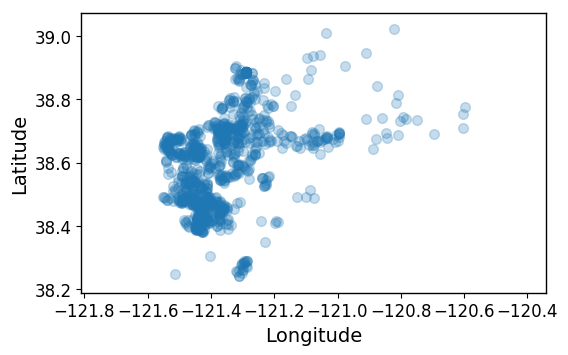

In [25]:
x = housing.select('longitude').rdd.map(lambda row: row[0]).collect()
y = housing.select('latitude').rdd.map(lambda row: row[0]).collect()
plt.scatter(x, y, alpha=0.25)
plt.axis('equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [26]:
housing.select('price', 'beds', 'baths', 'sqft', 'city').orderBy('price', ascending=True).show(10)

+-----+----+-----+----+-----------+
|price|beds|baths|sqft|       city|
+-----+----+-----+----+-----------+
| 1551|   3|    3|   0|    LINCOLN|
| 2000|   3|    4|5822|SLOUGHHOUSE|
| 4897|   0|    0|   0|    LINCOLN|
| 4897|   0|    0|   0|    LINCOLN|
| 4897|   0|    0|   0|    LINCOLN|
| 4897|   0|    0|   0|    LINCOLN|
| 4897|   0|    0|   0|    LINCOLN|
| 4897|   0|    0|   0|    LINCOLN|
| 4897|   0|    0|   0|    LINCOLN|
| 4897|   0|    0|   0|    LINCOLN|
+-----+----+-----+----+-----------+
only showing top 10 rows



In [27]:
housing.groupBy('price').count().orderBy('count', ascending=False).show(10)

+------+-----+
| price|count|
+------+-----+
|  4897|   49|
|220000|   10|
|250000|    9|
|150000|    9|
|170000|    9|
|205000|    8|
|145000|    7|
|180000|    7|
|225000|    7|
|200000|    7|
+------+-----+
only showing top 10 rows



In [28]:
housing.show(5)

+----------+-----+----+-----+----+-----------+-------------------+-----+---------+-----------+-----------+--------+-------------+
|      city|  zip|beds|baths|sqft|       type|          sale_date|price| latitude|  longitude|total_rooms|type_idx|     type_ohe|
+----------+-----+----+-----+----+-----------+-------------------+-----+---------+-----------+-----------+--------+-------------+
|SACRAMENTO|95838|   2|    1| 836|Residential|2008-05-21 00:00:00|59222|38.631913|-121.434879|          3|     0.0|(3,[0],[1.0])|
|SACRAMENTO|95823|   3|    1|1167|Residential|2008-05-21 00:00:00|68212|38.478902|-121.431028|          4|     0.0|(3,[0],[1.0])|
|SACRAMENTO|95815|   2|    1| 796|Residential|2008-05-21 00:00:00|68880|38.618305|-121.443839|          3|     0.0|(3,[0],[1.0])|
|SACRAMENTO|95815|   2|    1| 852|Residential|2008-05-21 00:00:00|69307|38.616835|-121.439146|          3|     0.0|(3,[0],[1.0])|
|SACRAMENTO|95824|   2|    1| 797|Residential|2008-05-21 00:00:00|81900| 38.51947|-121.435

In [29]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=['beds', 'type_ohe', 'baths', 'sqft', 'latitude', 'longitude'], outputCol="features")
df = vecAssembler.transform(housing)

### Make training, test split

In [30]:
df_train, df_test = df.select('price', 'features').randomSplit([0.7, 0.3], seed=1234)

In [31]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaler_model = scaler.fit(df_train)
df_train_std = scaler_model.transform(df_train).cache()
df_test_std = scaler_model.transform(df_test).cache()
df_train_std.show(10)

+-----+--------------------+--------------------+
|price|            features|      scaledFeatures|
+-----+--------------------+--------------------+
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|
+-----+--------------------+--------------------+
only showing top 10 rows



In [32]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=5, regParam=0.0, solver="normal", featuresCol='scaledFeatures', labelCol='price')
model = lr.fit(df_train_std)

In [33]:
y_pred_test = model.transform(df_test_std)
y_pred_test.show()

+-----+--------------------+--------------------+------------------+
|price|            features|      scaledFeatures|        prediction|
+-----+--------------------+--------------------+------------------+
| 1551|[3.0,1.0,0.0,0.0,...|[0.04163622442552...| 294502.5757414183|
| 2000|[3.0,1.0,0.0,0.0,...|[0.04163622442552...| 623221.7856989366|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142420.62899125216|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...| 142323.3101627456|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...| 142202.8073774785|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142320.17777135983|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142490.64526803087|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142326.74638902093|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142344.95337746068|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142397.23979881703|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142706.92378197913|
| 4897|(8,[1,6,7],[1.0,3...|[-2.26

In [34]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol='price')
evaluator.evaluate(y_pred_test, {evaluator.metricName: "r2"}), evaluator.evaluate(y_pred_test, {evaluator.metricName: "rmse"})

(0.21499077179173032, 116169.85279495588)

In [35]:
model.transform(df_train_std).show()

+-----+--------------------+--------------------+------------------+
|price|            features|      scaledFeatures|        prediction|
+-----+--------------------+--------------------+------------------+
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142439.82317463233|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142365.28404730133|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142348.21694821314|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|  142492.431301758|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...| 142328.8842708532|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...| 142495.6102061789|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142327.97311496251|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...| 142196.3081005608|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...| 142498.2843805527|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|142324.56076152105|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...| 142497.7763013572|
| 4897|(8,[1,6,7],[1.0,3...|[-2.26

In [36]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(numTrees=25, seed=42, featuresCol='scaledFeatures', labelCol='price')
model = rf.fit(df_train_std)
model.featureImportances

SparseVector(8, {0: 0.0585, 1: 0.0029, 2: 0.0077, 3: 0.0059, 4: 0.2489, 5: 0.2717, 6: 0.1744, 7: 0.2301})

In [37]:
y_pred_test = model.transform(df_test_std)
y_pred_test.show()

+-----+--------------------+--------------------+------------------+
|price|            features|      scaledFeatures|        prediction|
+-----+--------------------+--------------------+------------------+
| 1551|[3.0,1.0,0.0,0.0,...|[0.04163622442552...| 425918.0791275354|
| 2000|[3.0,1.0,0.0,0.0,...|[0.04163622442552...| 554763.6112857143|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...| 284752.1182292196|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|23093.115977510082|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|23093.115977510082|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|23093.115977510082|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|33408.698827486194|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|33408.698827486194|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|33408.698827486194|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|33408.698827486194|
| 4897|(8,[1,6,7],[1.0,3...|[-2.2643700514498...|33408.698827486194|
| 4897|(8,[1,6,7],[1.0,3...|[-2.26

In [38]:
evaluator.evaluate(y_pred_test, {evaluator.metricName: "r2"}), evaluator.evaluate(y_pred_test, {evaluator.metricName: "rmse"})

(0.5385439119638602, 89067.90720750975)

# Repeat the above in Sklearn

In [61]:
df_raw = pd.read_csv('Sacramentorealestatetransactions.csv', parse_dates=['sale_date'], header=0)
df_raw.rename(columns = {'sq__ft':'sqft'}, inplace = True)
df_raw.head()

,street,city,zip,state,beds,baths,sqft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,2008-05-21 04:00:00,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,2008-05-21 04:00:00,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,2008-05-21 04:00:00,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,2008-05-21 04:00:00,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,2008-05-21 04:00:00,81900,38.519470,-121.435768


In [62]:
df_raw.drop(['street', 'state', 'sale_date'], axis=1, inplace=True)

In [63]:
df_raw.groupby('type').agg({'price': [np.size, np.mean, np.min, np.max]})

price                               
              size           mean    amin    amax
type                                             
Condo           54  150082.185185   40000  360000
Multi-Family    13  224534.692308  100000  416767
Residential    917  239186.162486    1551  884790
Unkown           1  275000.000000  275000  275000

In [64]:
df_raw[(df_raw.sqft == 0) & (df_raw.beds == 0) & (df_raw.baths == 0)]

,city,zip,beds,baths,sqft,type,price,latitude,longitude
73,SACRAMENTO,95834,0,0,0,Residential,206000,38.631481,-121.501880
89,SACRAMENTO,95833,0,0,0,Residential,244500,38.626671,-121.525970
100,RANCHO CORDOVA,95742,0,0,0,Residential,263500,38.553867,-121.219141
121,RANCHO CORDOVA,95742,0,0,0,Residential,320000,38.528575,-121.228600
126,SACRAMENTO,95833,0,0,0,Residential,339500,38.602416,-121.542965
133,SACRAMENTO,95831,0,0,0,Residential,370000,38.477200,-121.521500
147,ELK GROVE,95624,0,0,0,Residential,445000,38.420338,-121.363757
153,FOLSOM,95630,0,0,0,Residential,585000,38.670947,-121.097727
169,RANCHO MURIETA,95683,0,0,0,Residential,97750,38.492287,-121.100032
192,ELK GROVE,95758,0,0,0,Condo,145000,38.423251,-121.444489


In [65]:
df_raw[(df_raw.sqft == 0) | (df_raw.beds == 0) | (df_raw.baths == 0)]

,city,zip,beds,baths,sqft,type,price,latitude,longitude
73,SACRAMENTO,95834,0,0,0,Residential,206000,38.631481,-121.501880
89,SACRAMENTO,95833,0,0,0,Residential,244500,38.626671,-121.525970
100,RANCHO CORDOVA,95742,0,0,0,Residential,263500,38.553867,-121.219141
121,RANCHO CORDOVA,95742,0,0,0,Residential,320000,38.528575,-121.228600
126,SACRAMENTO,95833,0,0,0,Residential,339500,38.602416,-121.542965
132,EL DORADO HILLS,95762,3,2,0,Residential,352000,38.691299,-121.081752
133,SACRAMENTO,95831,0,0,0,Residential,370000,38.477200,-121.521500
147,ELK GROVE,95624,0,0,0,Residential,445000,38.420338,-121.363757
153,FOLSOM,95630,0,0,0,Residential,585000,38.670947,-121.097727
154,EL DORADO HILLS,95762,4,3,0,Residential,600000,38.672761,-121.050378


In [66]:
pd.get_dummies(df_raw, columns=['type'])

,city,zip,beds,baths,sqft,price,latitude,longitude,type_Condo,type_Multi-Family,type_Residential,type_Unkown
0,SACRAMENTO,95838,2,1,836,59222,38.631913,-121.434879,0,0,1,0
1,SACRAMENTO,95823,3,1,1167,68212,38.478902,-121.431028,0,0,1,0
2,SACRAMENTO,95815,2,1,796,68880,38.618305,-121.443839,0,0,1,0
3,SACRAMENTO,95815,2,1,852,69307,38.616835,-121.439146,0,0,1,0
4,SACRAMENTO,95824,2,1,797,81900,38.519470,-121.435768,0,0,1,0
5,SACRAMENTO,95841,3,1,1122,89921,38.662595,-121.327813,1,0,0,0
6,SACRAMENTO,95842,3,2,1104,90895,38.681659,-121.351705,0,0,1,0
7,SACRAMENTO,95820,3,1,1177,91002,38.535092,-121.481367,0,0,1,0
8,RANCHO CORDOVA,95670,2,2,941,94905,38.621188,-121.270555,1,0,0,0
9,RIO LINDA,95673,3,2,1146,98937,38.700909,-121.442979,0,0,1,0


In [80]:
zip_group = df_raw.groupby('zip').agg({'price':[np.size, np.mean]}).sort_values([(u'price', u'mean')])
zip_group

price               
       size           mean
zip                       
95648    72   96539.263889
95824    12  114467.583333
95815    18  115133.000000
95626     4  132866.000000
95660    21  135659.333333
95842    22  143281.772727
95820    23  143371.478261
95838    37  149461.351351
95817     7  151122.714286
95822    24  157677.666667
95691     3  170700.000000
95673    13  172727.615385
95832    12  175196.833333
95823    61  175243.049180
95621    28  177284.571429
95826    18  181119.944444
95828    45  184676.955556
95825    13  189686.769231
95631     1  194818.000000
95833    20  198765.900000
95827     9  204104.111111
95841     7  213806.142857
95619     1  216033.000000
95683     4  223812.500000
95610     7  226436.285714
95821     6  228666.666667
95722     1  230000.000000
95758    44  231969.250000
95843    33  232496.393939
95670    21  236060.285714
...     ...            ...
95835    37  276275.918919
95662    11  279159.545455
95818     7  283217.714286
95829    11  294142.454545
95608    20  295684.750000
95614     1  300000.000000
95628     9  303500.666667
95831    10  313271.000000
95757    36  338334.583333
95816     4  348750.000000
95742    11  350009.090909
95765    11  355214.909091
95661     8  360903.250000
95667    10  363863.400000
95864     5  364400.000000
95747    20  364660.650000
95814     3  367728.666667
95690     1  380000.000000
95635     1  395000.000000
95811     2  403474.000000
95603     5  405890.800000
95630    17  414960.176471
95677     6  430640.833333
95819     4  465750.000000
95633     1  490000.000000
95762    23  491698.956522
95663     1  506688.000000
95650     2  567000.000000
95693     5  617508.400000
95746     3  678733.333333

[68 rows x 2 columns]

In [68]:
df_raw.zip.value_counts()

95648    72
95823    61
95828    45
95758    44
95838    37
95835    37
95757    36
95624    34
95843    33
95621    28
95822    24
95820    23
95762    23
95842    22
95834    22
95632    21
95660    21
95670    21
95608    20
95678    20
95833    20
95747    20
95815    18
95826    18
95630    17
95825    13
95673    13
95824    12
95832    12
95742    11
         ..
95661     8
95610     7
95817     7
95818     7
95841     7
95677     6
95821     6
95864     5
95603     5
95693     5
95819     4
95816     4
95683     4
95626     4
95726     3
95691     3
95814     3
95746     3
95623     2
95650     2
95811     2
95614     1
95619     1
95663     1
95631     1
95633     1
95635     1
95655     1
95690     1
95722     1
Name: zip, Length: 68, dtype: int64

In [ ]:
plt.scatter(df_raw['sqft'], df_raw['price'])
plt.xlabel('Square feet')
plt.ylabel('Price')

In [ ]:
plt.scatter(df_raw['beds'], df_raw['price'], alpha=0.25)
plt.xlabel('Beds')
plt.ylabel('Price')

In [ ]:
plt.scatter(df_raw['baths'], df_raw['price'], alpha=0.25)
plt.xlabel('Baths')
plt.ylabel('Price')

In [ ]:
df_raw[['price', 'beds', 'baths', 'sq__ft']].corr()

In [ ]:
df_raw.info()

In [ ]:
df_raw.sale_date.value_counts()